# Different implementations of a Marine Data Science application

For a given sea-surface height field `ssh`, we want to calculate the domain-wide spatial average of kinetic energy (via geostrophic surface velocities).
We want this `ssh` field to live on a torus (which implies cyclic boundary conditions in, both, y and x).

For a given set of coordinates
$$
time=\{time_{l}\}\qquad lat=\{lat_{j}\}\qquad lon=\{lon_{i}\}
$$
(one-dimensional arrays of points in time and positions in the spatial domain), we get a time-series
$$
e(ssh, time, lat, lon, G, F) = \{e_l\}
$$

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# parameters
rng_seed = 12345

Ntime = 30  # number of time steps
Nlat = 20  # number of grid points in latitude direction
Nlon = 10  # number of grid points in longitude

dlat = 200e3  # grid constant in lat (in meters)
dlon = 400e3  # grid constant in lon (in meters)

G0 = 9.81  # graviational acceleration (in meters / second^2)

F0 = 2 * 7.2921e-5 * 0.5  # Coriolis parameter (in 1/second) at 30 N

In [3]:
time = np.arange(Ntime)  # time vector
lat = np.arange(Nlat) * dlat  # positions in lat
lon = np.arange(Nlon) * dlon  # positions in lon

# chose a random sea level field
np.random.seed(rng_seed)
ssh = 3 * np.random.normal(size=(Ntime, Nlat, Nlon))

## Implemetation 1

In [4]:
def energy_average_1(ssh=None, time=None, lat=None, lon=None, G=G0, F=F0):
    
    # get grid constant
    dlat = lat[1] - lat[0]
    dlon = lon[1] - lon[0]
    
    # calculate u and v using geostrophy
    u = - G / F * np.diff(ssh[:, np.arange(-1, lat.size), :], axis=1) / dlat
    v = G / F * np.diff(ssh[:, :, np.arange(-1, lon.size)], axis=2) / dlon
    
    # calculate energy
    e = 0.5 * (u ** 2 + v ** 2)
    
    # average energy in x and y
    e_ave = e.mean(axis=-1).mean(axis=-1)
    
    return e_ave

## Implemetation 2

In [5]:
def energy_average_2(ssh=None, time=None, lat=None, lon=None, G=G0, F=F0):

    # get grid constant
    dlat = lat[1] - lat[0]
    dlon = lon[1] - lon[0]
    
    # calculate u and v using geostrophy
    u = -G / F * np.diff(ssh[:, :, :-1], axis=1) / dlat
    v = G / F * np.diff(ssh[:, :-1, :], axis=2) / dlon
    
    # calculate energy
    e = 0.5 * (u ** 2 + v ** 2)
    
    # average energy in x and y
    e_ave = e.mean(axis=-1).mean(axis=-1)
    
    return e_ave

## Compare implementations

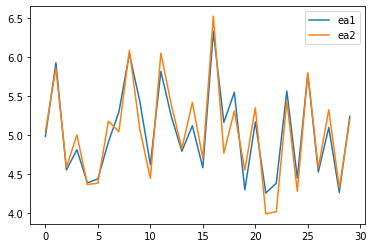

In [6]:
plt.plot(time, energy_average_1(ssh, time, lat, lon, G=G0, F=F0), label="ea1");
plt.plot(time, energy_average_2(ssh, time, lat, lon, G=G0, F=F0), label="ea2");
plt.gca().legend();

In [7]:
print(np.allclose(
    energy_average_1(ssh, time, lat, lon, G=G0, F=F0),
    energy_average_2(ssh, time, lat, lon, G=G0, F=F0)
))

False


## Check metamorphic relations for implementation 1

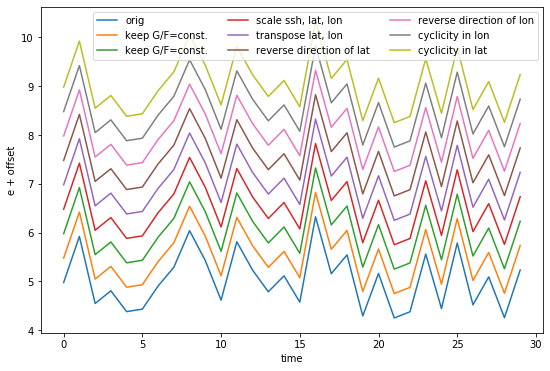

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6)) 

eave = energy_average_1

ax.plot(time, eave(ssh, time, lat, lon, G=G0, F=F0), label="orig")
ax.plot(time, eave(ssh, time, lat, lon, G=G0 * 5, F=F0 * 5) + 0.5, label="keep G/F=const.")
ax.plot(time, eave(ssh, time, lat, lon, G=1, F=F0/G0) + 1.0, label="keep G/F=const.")
ax.plot(time, eave(7 * ssh, time, 7 * lat, 7 * lon) + 1.5, label="scale ssh, lat, lon")
ax.plot(time, eave(ssh.transpose([0, 2, 1]), time, lat=lon, lon=lat) + 2.0, label="transpose lat, lon")
ax.plot(time, eave(ssh[:, ::-1, :], time, lat=lat[::-1], lon=lon) + 2.5, label="reverse direction of lat")
ax.plot(time, eave(ssh[:, ::-1], time, lat=lat, lon=lon[::-1]) + 3.0, label="reverse direction of lon")
ax.plot(time, eave(np.roll(ssh, 7, axis=-1), time, lat, lon=np.roll(lon, 7)) + 3.5, label="cyclicity in lon")
ax.plot(time, eave(np.roll(ssh, 7, axis=-2), time, lat=np.roll(lat, 7), lon=lon) + 4.0, label="cyclicity in lat")

ax.set_xlabel("time")
ax.set_ylabel("e + offset")

ax.legend(ncol=3);

## Check metamorphic relations for implementation 2

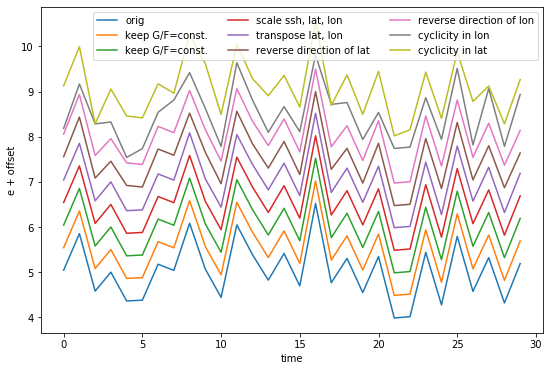

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6)) 

eave = energy_average_2

ax.plot(time, eave(ssh, time, lat, lon, G=G0, F=F0), label="orig")
ax.plot(time, eave(ssh, time, lat, lon, G=G0 * 5, F=F0 * 5) + 0.5, label="keep G/F=const.")
ax.plot(time, eave(ssh, time, lat, lon, G=1, F=F0/G0) + 1.0, label="keep G/F=const.")
ax.plot(time, eave(7 * ssh, time, 7 * lat, 7 * lon) + 1.5, label="scale ssh, lat, lon")
ax.plot(time, eave(ssh.transpose([0, 2, 1]), time, lat=lon, lon=lat) + 2.0, label="transpose lat, lon")
ax.plot(time, eave(ssh[:, ::-1, :], time, lat=lat[::-1], lon=lon) + 2.5, label="reverse direction of lat")
ax.plot(time, eave(ssh[:, ::-1], time, lat=lat, lon=lon[::-1]) + 3.0, label="reverse direction of lon")
ax.plot(time, eave(np.roll(ssh, 7, axis=-1), time, lat, lon=np.roll(lon, 7)) + 3.5, label="cyclicity in lon")
ax.plot(time, eave(np.roll(ssh, 7, axis=-2), time, lat=np.roll(lat, 7), lon=lon) + 4.0, label="cyclicity in lat")

ax.set_xlabel("time")
ax.set_ylabel("e + offset")

ax.legend(ncol=3);

And we find that `energy_average_2()` does not account for cyclicity.